# Nullify Image Perspective

## A fun illustration of affine transform and bilinear interpolation

iPython Notebook created by Leland Sun, Dec. 2015

#### Given a photograph taken off-axis of a planar subject, we can reverse the perspective effect of the camera angle and display the subject without the geometric distortions due to perspective.

<table border="0" style="width:80%;border:0px"> <tr style="border:0px">
    <td style="width:50%;border:0px">
        <img src="images/tapestry.jpg" width="200px"/>
    </td>
    <td style="width:50%;border:0px">
        <img src="images/tapestry rectified.jpg" width="265px"/>
    </td>
</tr> </table>

In translating between the 2D coordinates of the image and the 2D coordinates of the subject, we need to consider the relationship in 3D space between the camera apparatus and the subject. We are going to employ two 3D coordinate systems that share the same point of origin -- the camera "center". This is the point at which light rays converge in forming the image at the film or digital sensor element.

### The camera basis
Although in actuality the image detection happens behind the camera center, it is simpler to think of the image plane as positioned in front of the camera. The zeroth basis vector in the camera basis goes from the camera center (origin) to the center of the top-left corner pixel of this virtual sensor element. There is also a vertical basis vector that goes from the top-left to the bottom-left sensor corner pixel, and a horizontal basis vector that goes from the top-left to the top-right sensor corner pixel, center-to-center. 

### The subject basis
For the subject basis, we first demarcate a rectangular area of interest and designate its pixel dimensions. The zeroth basis vector in the subject basis goes from the camera center (origin) to the center of the top-left corner pixel of the subject rectangle. There is also a vertical basis vector that goes from the top-left to the bottom-left subject corner pixel, and a horizontal basis vector that goes from the top-left to the top-right subject corner pixel, center-to-center. 

<em>To maintain the same ordering of dimensions when indexing into image arrays, we will give vertical coordinate before horizontal coordinate. So, in 2-dimensions, we will use ordered pair $(y, x)$.</em>

### Overall strategy
Our coordinate translation relies on two transform operations. For any given point on the image plane, we want to transform between its coordinates $(p_0,p_y,p_x)$ in the camera basis and its coordinates $(u_0,u_y,u_x)$ in the subject basis. Change of basis is a matrix-multiplication operation. There exists a matrix $H$ such that 
\\[
\begin{bmatrix} \\ & H & \\ & & \end{bmatrix} 
\begin{bmatrix} p_0 \\ p_y \\ p_x \end{bmatrix} = 
\begin{bmatrix} u_0 \\ u_y \\ u_x \end{bmatrix}
\\]

We also want to project from the origin through points $u$ on the image plane to points $v$ on the subject plane. That is, each pair of associated $u$ and $v$ points are lined up to the origin. Within the subject basis, this projection is a scaling operation. We know $v_0$ must $=1$, so 
\\[
\begin{bmatrix} v_0 \\ v_y \\ v_x \end{bmatrix} = 
\begin{bmatrix} u_0 \\ u_y \\ u_x \end{bmatrix} \;\times \displaystyle\frac{1}{\,u_0}
\\]

Because we don't know the values of the camera nor of the subject bases, we would compute $H$ by observing its effect on known points:
\begin{equation}
\begin{bmatrix} 
    \color{Brown}{h_{p_0,u_0}} & \color{Brown}{h_{p_y,u_0}} & \color{Brown}{h_{p_x,u_0}} \\ 
    \color{Brown}{h_{p_0,u_y}} & \color{Brown}{h_{p_y,u_y}} & \color{Brown}{h_{p_x,u_y}} \\ 
    \color{Brown}{h_{p_0,u_x}} & \color{Brown}{h_{p_y,u_x}} & \color{Brown}{h_{p_x,u_x}} 
\end{bmatrix} 
\begin{bmatrix} 1 \\ \color{blue}{p_y} \\ \color{blue}{p_x} \end{bmatrix} = 
\begin{bmatrix} \color{darkgray}{u_0} \\ \color{darkgray}{u_y} \\ \color{darkgray}{u_x} \end{bmatrix} = 
\begin{bmatrix} 
    \color{darkgray}{u_0} \\ \color{blue}{v_y}\cdot\color{darkgray}{u_0} \\ \color{blue}{v_x}\cdot\color{darkgray}{u_0} 
\end{bmatrix} \tag{1} \\
\end{equation}

Although we don't have access to $\color{darkgray}{u_0,u_y,u_x}$, we can observe that certain pixel coordinates $(\color{Blue}{p_y,p_x})$ are mapped to certain subject coordinates $(\color{Blue}{v_y,v_x})$. This implies certain relationships amongst the unknown entries of $\color{Brown}H$ that can be expressed in linear equations in these variables. When we have nine suitable such equations, we can solve the linear system for these nine entries.

Let's see how this is done step by step.

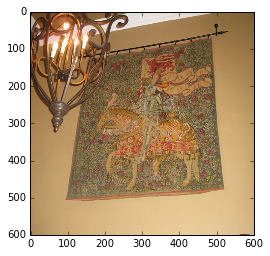

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
I = np.array(plt.imread('images/tapestry.jpg'))

plt.imshow(I)
plt.show()

In this image, the outline of the tapestry constitutes our rectangle of interest. It is known that the tapestry has a 4:5 aspect ratio, so we designate that the rectangle would be represented by 400 pixels across by 500 pixels down. (Because in our color manipulation we only do interpolation and no color blending, we would want the output resolution to be at least as fine as the input.) 

With the help from an image viewer program, we identify the four corners of the tapestry image to be located at pixel coordinates $\color{gray}{(y,x):} \ (127,151)$, $(69,486)$, $(506,94)$, and $(478,519)$, which when divided by the number of pixel intervals down and across yield their coordinates, all at $p_0=1$, in the camera basis. These four corners correspond to the four points on the subject plane $(0,0)$, $(0,1)$, $(1,0)$, and $(1,1)$, all at $v_0=1$, in the subject basis. We thus establish four associations of coordinates between the input image and the rectified representation of the subject.

In [2]:
# all coordinates in y, x order
image_size = (600, 600)
src_pts = [(127,151), (69,486), (506,94), (478,519)]
p_pts = src_pts / (np.array(image_size) - (1,1))
subj_size = (500, 400)

In solving for the change-of-basis matrix $\color{Brown}H$, we would represent each linear equation in the form of a dot product between a vector $\mathbf{w}$ of nine coefficients and the vector $\mathbf{\color{Brown}h}$ of the nine unknown entries of $\color{Brown}H$ to equal a scalar right-hand-side quantity $b$.
\\[ \mathbf{w} \cdot \mathbf{\color{Brown}h} = b \\]

From matrix eq. (1), we can work out two linear equations for each corresponding pair of input and output coordinates:
\begin{align}
    \color{Blue}{v_y}(h_{p_0,u_0} + \color{Blue}{p_y} h_{p_y,u_0} + \color{Blue}{p_x} h_{p_x,u_0}) 
    - h_{p_0,u_y} - \color{Blue}{p_y} h_{p_y,u_y} - \color{Blue}{p_x} h_{p_x,u_y} &= 0 \\ 
    \color{Blue}{v_x}(h_{p_0,u_0} + \color{Blue}{p_y} h_{p_y,u_0} + \color{Blue}{p_x} h_{p_x,u_0}) 
    - h_{p_0,u_x} - \color{Blue}{p_y} h_{p_y,u_x} - \color{Blue}{p_x} h_{p_x,u_x} &= 0
\end{align}

In [3]:
def make_2_equations(p, v):
    return [[v[0], v[0]*p[0], v[0]*p[1], -1, -p[0], -p[1], 0, 0, 0],
    [v[1], v[1]*p[0], v[1]*p[1], 0, 0, 0, -1, -p[0], -p[1]]]


def make_8_equations(p_pts):
    coef_list = []
    v_pts = [(0.,0.), (0., 1.), (1., 0.), (1., 1.)]
    for (p, v) in zip(p_pts, v_pts):
        coef_list.extend( make_2_equations(*(p, v)) )
    rhs = [0.] * 8
    return coef_list, rhs


coef_list, rhs = make_8_equations(p_pts)
for x in coef_list: print(x)

[0.0, 0.0, 0.0, -1, -0.21202003338898165, -0.25208681135225375, 0, 0, 0]
[0.0, 0.0, 0.0, 0, 0, 0, -1, -0.21202003338898165, -0.25208681135225375]
[0.0, 0.0, 0.0, -1, -0.11519198664440734, -0.81135225375626041, 0, 0, 0]
[1.0, 0.11519198664440734, 0.81135225375626041, 0, 0, 0, -1, -0.11519198664440734, -0.81135225375626041]
[1.0, 0.84474123539232049, 0.15692821368948248, -1, -0.84474123539232049, -0.15692821368948248, 0, 0, 0]
[0.0, 0.0, 0.0, 0, 0, 0, -1, -0.84474123539232049, -0.15692821368948248]
[1.0, 0.79799666110183642, 0.86644407345575958, -1, -0.79799666110183642, -0.86644407345575958, 0, 0, 0]
[1.0, 0.79799666110183642, 0.86644407345575958, 0, 0, 0, -1, -0.79799666110183642, -0.86644407345575958]


These coordinate pairings give us eight of the nine needed equations to solve for $\color{Brown}h$. It turns out that they do not resolve the question of scale -- the subject might be very big and far away, or small and close up. It doesn't really matter either way, but in order to pin down <em>some</em> matrix $\color{Brown}H$ that satisfies this correspondence of points, we need to establish some arbitrary scale. We can do so simply by requiring that some entry be equal to 1. This would constitute our ninth linear equation.

In [4]:
def complete_and_solve(coef_list, rhs):
    eq9 = [1. if x == 4 else 0. for x in range(9)]
    h = np.linalg.solve(coef_list + [eq9], rhs + [1.])
    return np.matrix( np.reshape(h, (3,3)) )


H = complete_and_solve(coef_list, rhs)
H

matrix([[ 0.41306589,  0.21793192,  0.12160984],
        [-0.25566491,  1.        ,  0.17313433],
        [-0.27987363,  0.14822432,  0.98556168]])

Invoking numpy's solve function with our nine linear equations yields the matrix $H$ for transforming camera coordinates into subject coordinates. We can test it by computing the $u$ points corresponding to our four corner $p$ points. We see that when scaled by $1/u_0$, they agree with the values of our initial $v$ points, within some rounding errors on the order of $10^{-16}$.

In [5]:
u_pts = [(H * np.matrix([1,y,x]).transpose()).flatten().tolist()[0] for (y,x) in p_pts]

for u in u_pts: print(u[1] / u[0], u[2] / u[0])

-5.665234969490234e-17 9.91416119660791e-17
1.8095674521443123e-16 1.0
1.0 4.503976727055998e-17
1.0 1.0


Our change-of-basis matrix works, but what we really want to do is to transform in the reverse direction, from subject (output) coordinates to camera (input) coordinates, so that we can pick out a color for each <em>output</em> pixel using bilinear interpolation of <em>input</em> colors. We might apply the inverse of matrix $H$, but before that we'll first need to scale each $v$ point by a variable factor $u_0$. Because $u_0$ varies linearly with the corresponding camera coordinates, when we have determined $u_0$, we might as well have determined the sought-after coordinates. So, we won't need to use $H^{-1}$.

### A geometric perspective

When we computed $u\_pts$ from our transform matrix and $p\_pts$, we have more than just retrieved the initial 2D $v\_pts$. In the 3D coordinates of $u\_pts$, our matrix $H$ has given us the geometric context we need to translate coordinates in either direction. Let's study the depth aspect of this geometry by considering a 2D slice through the camera center and cutting across the image plane.

The projection of the zeroth subject basis vector onto our 2D slice cuts across the image plane at a point which we'll call reference point $A$. The line from the camera center to the other extreme of the subject area cuts across the image plane at what we'll call reference point $B$. For this discussion, let's simplify the camera basis and just consider the position of a point along the image plane (line) as a 1-dimensional vector $p$ with $A$ as origin and distance at $B$ normalized to 1. In the subject basis, a point along the image line has coordinates $(u_0, u_1)$, which we'll label as $(Au_0, Au_1)$ for $A$ and $(Bu_0, Bu_1)$ for $B$. Recall that $(u_0, u_1)$ is a scaled version of a point $(1, v)$ on the subject plane, such that $v = u_1 / u_0$. 

When we draw the vector $u_1$, we see that this line segment and vector $p$ represent two sides of similar triangles as we move $p$ along the image line, so these two quantities are proportional by a constant. (To clarify that we are referring to an overlaying line segment and not the numeric value of $u_1$, let's denote it as $\overline{u_1}$.) However, it is important to note that the <em>numeric value</em> of $u_1$ is on the contrary <em>not</em> proportional to $p$ by a constant, becuase the numeric value is further affected by a scaling that varies with respect to $p$. This also means $v \neq \overline{u_1} \,/\, \overline{u_0}$. We can, nevertheless, derive $v$ geometrically, by considering $\overline{u_1}$ relative to the extension of $\overline{u_1}$ that lies between the sight lines through $A$ and $B$ from the camera center. This is the reference quantity at the current scaling corresponding to the length $1$ at the subject plane. 

Therefore, at $B$, $v = \overline{Bu_1} \,/\, \overline{Bu_1}$, which equals $1$ as we would expect. As we move away from $B$, the numerator is scaled by $p$, while the denominator is by virtue of similar triangles scaled by the ratio of $\overline{u_0} \,/\, \overline{Bu_0}$, which can be expressed in terms of $p$ and the ratio of known constants $\mathrm{R = Au_0 / Bu_0}$. Putting these together:
\\begin{align}
    v &= \frac{p}{\big(Au_0\, (1 - p) + Bu_0\, p\big) \,/\, Bu_0} = \frac{p}{\mathrm{R}\, (1-p) + p}
\\end{align}

Solve for $p$ in terms of $v$, and we can then translate from subject coordinates into source image coordinates:
\\begin{align}
    p &= v\, \big(\mathrm{R}\,(1-p) + p\big) = \mathrm{R}\,v - \mathrm{R}\,vp + vp \\\
    p + \mathrm{R}\,vp - vp &= \mathrm{R}\,v \\\
    \color{Blue}{p} & \color{Blue}{\; = \frac{\mathrm{R}\,v}{1 + (\mathrm{R}-1)\,v}}
\\end{align}


In [6]:
def get_p_from_v(v, u0_ratio):
    '''
    v = subject vector normalized to 1 from A to B
    u0_ratio = Au_0 / Bu_0
    returns p = source image vector scaled to 1 from A to B
    '''
    return u0_ratio * v / (1 + (u0_ratio - 1) * v)

Thus, with two anchor points, we can derive all the points along the line passing through them. And with $2 \times 2$ anchor points, we can first derive anchoring data along two columns, which provides us with two anchor points for each row in the 2-dimensional array.

In [7]:
def frange(start, length, subj_len):
    '''
    The inputs are integer pixel references.
    Generates sequence of floating-point values, 
    normalized by (subj_len - 1).
    '''
    divisor = subj_len - 1
    for i in range(start, start + length):
        yield i / divisor


def get_p_seq_from_v(v_range, u0_ratio):
    '''
    v_range = generator of floating-point sequence
    u0_ratio = Au_0 / Bu_0 for this row (or column)
    yields sequence of p values
    '''
    for v in v_range:
        yield get_p_from_v(v, u0_ratio)


def interpolate(ctrl_val, ref_0, ref_1):
    return ref_0 + (ref_1 - ref_0) * ctrl_val


def map_to_source_coord(origin, size, subj_size, p_pts, u_pts):
    '''
    generator of source image coordinates
    p_pts: 2 x 2 sets of (p_y, p_x) ordered pairs at the corners of the subject
    u_pts: corresponding (u_0, u_y, u_x) 3D coordinates in subject basis
    yields floating-point coordinates normalized to the extents of the source image 
    '''
    u_pts = np.array(u_pts).reshape(2,2,3)
    p_pts = np.array(p_pts).reshape(2,2,2)

    # Derive anchor data in two columns.
    u_ratios = u_pts[0,:,0] / u_pts[1,:,0]       # [left_col_ratio, right_col_ratio]
    l_refs = get_p_seq_from_v(frange(origin[0], size[0], subj_size[0]), u_ratios[0])
    r_refs = get_p_seq_from_v(frange(origin[0], size[0], subj_size[0]), u_ratios[1])

    for l_ref, r_ref, v_y in zip(l_refs, r_refs, range(size[0])):
        # Derive row data from anchor points.
        row_u_ratio = interpolate(l_ref, u_pts[0,0,0], u_pts[1,0,0]) \
                    / interpolate(r_ref, u_pts[0,1,0], u_pts[1,1,0])
        l_pt = interpolate(l_ref, p_pts[0,0,:], p_pts[1,0,:])
        r_pt = interpolate(r_ref, p_pts[0,1,:], p_pts[1,1,:])
        for h_step, v_x in zip(frange(origin[1], size[1], subj_size[1]), range(size[1])):
            h_pos = get_p_from_v(h_step, row_u_ratio) 
            yield interpolate(h_pos, l_pt, r_pt), (v_y, v_x)


test_size = 3,3
for p, v in map_to_source_coord((0,0), test_size, test_size, p_pts, u_pts):
    print(p * np.array([599,599]))

[ 127.  151.]
[  99.32493388  310.84736467]
[  69.  486.]
[ 294.86032492  125.75451578]
[ 272.45290006  303.49762741]
[ 247.62855215  500.41257267]
[ 506.   94.]
[ 492.81412707  294.14271406]
[ 478.  519.]


As a minimal check, we divide the subject rectangle into a small grid to verify that in the corners we indeed get back our original src_pts: (127,151), (69,486), (506,94), and (478,519).

Now we are ready to construct our output image by applying for each output pixel a bilinear interpolation of the four immediate neighbor pixels around the pinpointed spot amongst the input pixels.

In [8]:
def bilinear(y, x, refs):
    '''
    refs is a 4-tuple of anchor ouput values corresponding to (y,x): (0,0), (0,1), (1,0), (1,1)
    '''
    return (1-x) * ((1-y) * refs[0] + y * refs[2]) + x * ((1-y) * refs[1] + y * refs[3])
    return (1-y) * ((1-x) * refs[0] + x * refs[1]) + y * ((1-x) * refs[2] + x * refs[3])


def compose_subject(src, origin, size, subj_size, p_pts, u_pts):
    '''
    src: source image array
    origin, size: 2-tuples in subject coordinate, specifying the desired (ver, hor) output framing
    subj_size: division of the designated subject rectangle into pixel height and width
    p_pts: 2 x 2 sets of (p_y, p_x) ordered pairs at the corners of the subject
    u_pts: corresponding (u_0, u_y, u_x) 3D coordinates in subject basis
    '''
    if len(src.shape) < 2 or len(src.shape) > 3:
        raise ValueError('src is not a recognizable image data array')
    if len(origin) != 2 or len(size) != 2 or len(subj_size) != 2:
        raise ValueError('origin, size and subj_size need to specify (ver, hor) components')

    # Create and initialize a white canvas
    white = 1. if src.dtype == np.float32 else 255
    if len(src.shape) == 3:    # there exists a 3rd dimension of color channels
        output = np.array([[[white] * src.shape[2]] * size[1]] * size[0], dtype = src.dtype)

    else:                      # we're in single-channel grayscale format
        output = np.array([[white] * size[1]] * size[0], dtype = src.dtype)

    for p, (y, x) in map_to_source_coord(origin, size, subj_size, p_pts, u_pts):

        # If coordinate is within the extent of the input image, ...
        if p[0] >= 0 and p[1] >= 0 and p[0] < 1 and p[1] < 1:

            # scaling dimensions to pixels & separate into integer & fractional parts
            p_frac, p_int = np.modf(p * (np.array(src.shape[:2]) - (1,1)))
            neighbors = p_int.astype(int) + ((0,0), (0,1), (1,0), (1,1))

            if len(src.shape) == 3:    # there exists a 3rd dimension of color channels
                for chan in range(src.shape[2]):
                    refs = [src[n[0], n[1], chan] for n in neighbors]
                    output[y, x, chan] = bilinear(*p_frac, refs)

            else:                      # we're in single-channel grayscale format
                refs = [src[n[0], n[1]] for n in neighbors]
                output[y, x] = bilinear(*p_frac, refs)

    return output

Let's see the result of our work. By controlling the origin and size parameters, we can specify an area independent from our designation of the subject rectangle. We'll include an extra 50 pixels all the way around the tapestry. (Be mindful that recalculation of the output image may take half a minute for this image size. Take this into consideration, before you get ambitious in transforming images of multi-megapixels.)

In [9]:
# grayscale images are also supported
# G = np.array(plt.imread('images/tapestry-gray.jpg'))

ypixels, xpixels = 600, 500
S = compose_subject(I, (-50, -50), (ypixels, xpixels), subj_size, p_pts, u_pts)

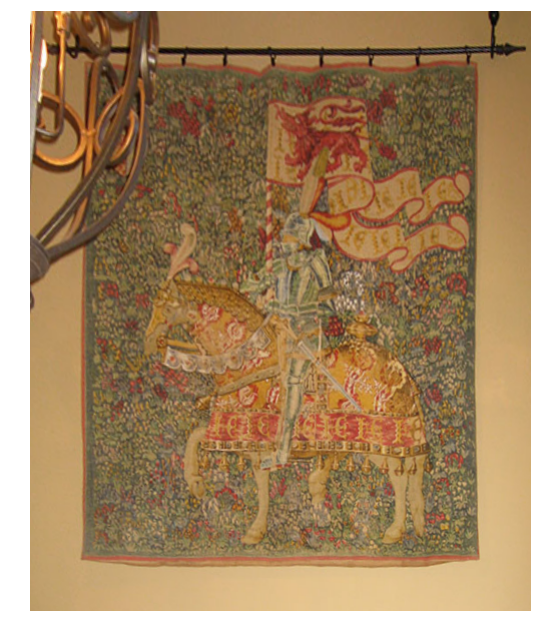

In [10]:
import matplotlib.cm as cm

dpi = 72
axes_sz = [0., 0., 1., 1.]

def display_image(image_array, ypixels, xpixels):
    fig_sz = xpixels / dpi, ypixels / dpi       # width / height in inches
    fig = plt.figure(figsize=fig_sz, dpi=dpi, frameon=False)
    ax = fig.add_axes(axes_sz)
    ax.set_axis_off()                           # turns off tick marks
    ax.imshow(image_array, cmap=cm.Greys_r)     # cmap ignored for RGB/RGBA image data
    plt.show(fig)

display_image(S, ypixels, xpixels)

We can also save the result image to file.

In [11]:
def save_image(filespec, image_array, ypixels, xpixels):
    fig_sz = xpixels / dpi, ypixels / dpi       # width / height in inches
    fig = plt.figure(figsize=fig_sz, dpi=dpi, frameon=False)
    ax = fig.add_axes(axes_sz)
    ax.set_axis_off()                           # turns off tick marks
    ax.imshow(image_array, cmap=cm.Greys_r)     # cmap ignored for RGB/RGBA image data
    plt.savefig(filespec)
    plt.close(fig)

save_image('images/output.jpg', S, ypixels, xpixels)

#### To try these codes with your own image data, use the following function, which accepts all the necessary parameters. <br>You will need to supply the input image, designate its reference src_pts and subj_size, frame your output image, and run the code cell.

In [ ]:
def nullify_perspective(src_filespec, op_origin, op_size, subj_size, src_pts):
    '''
    points are to be given as (y, x) ordered pairs
    sizes are to be given as (height, width) ordered pairs
    '''
    if np.array(src_pts).shape != (4,2):
        raise ValueError('src_pts should be four (y, x) corners of subject in source image')
    if np.array(subj_size).shape != (2,):
        raise ValueError('subj_size should specify subject (height, width) in output image')
    if np.array(op_origin).shape != (2,) or np.array(op_size).shape != (2,):
        raise ValueError('use 2-tuples op_origin and op_size to frame the output image')

    src = np.array(plt.imread(src_filespec))
    p_pts = src_pts / (np.array(src.shape[:2]) - (1,1))
    eq_list, rhs = make_8_equations(p_pts)
    H = complete_and_solve(eq_list, rhs)
    u_pts = [(H * np.matrix([1,y,x]).transpose()).flatten().tolist()[0] for (y,x) in p_pts]
    return compose_subject(src, op_origin, op_size, subj_size, p_pts, u_pts)


# Follow this template to set your custom parameters:
my_src_pts = [(127,151), (69,486), (506,94), (478,519)]
my_op_size = 600, 500
my_subj_size = 500, 400
my_image = nullify_perspective('images/tapestry.jpg', (-50,-50), my_op_size, my_subj_size, my_src_pts)
display_image(my_image, *my_op_size)
save_image('images/my_output.jpg', my_image, *my_op_size)